# Tutorial interpolation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from ropwr import RobustPWRegression

## Basic

This tutorial shows the capabilities of the robust piecewise regression class to be used as an interpolator. Two well-known application in quantitative finance, the interpolation of yield curves and probability default curves, will serve as examples.

First, we are interested in interpolating a discount curve given by a set of discount factors and maturities. To simplify the problem, we use times instead of maturities. This example is presented in https://www.quantlib.org/slides/dima-ql-intro-2.pdf (slide 90).

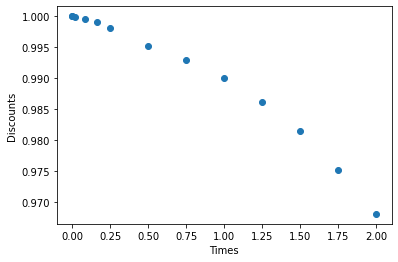

In [3]:
times = np.array([0.0, 1/365, 1/52, 1/12, 2/12, 3/12, 6/12, 9/12, 1, 5/4, 6/4, 7/4, 2])

discounts = np.array([1.0000000, 0.9999656, 0.9999072, 0.9996074, 0.9990040,
                      0.9981237, 0.9951358, 0.9929456, 0.9899849, 0.9861596,
                      0.9815178, 0.9752363, 0.9680804])

plt.scatter(times, discounts)
plt.xlabel('Times')
plt.ylabel('Discounts')
plt.show()

Note that interpolation requires the regression funtion $f$ at the known points $(x_i, y_i)$ to satisfy $f(x_i) = y_i$. Therefore, splits points must be $x_i$, $i=1,\ldots, n$. Also, note that the default parameter ``continuous_deriv=True`` results in spline interpolation.

We generate a time space to calculate interpolated values.

In [4]:
time_space = np.linspace(1/365, 2, 1000)

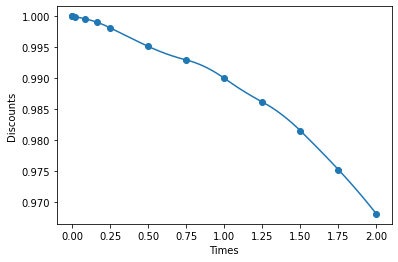

In [5]:
pw = RobustPWRegression(degree=2, monotonic_trend="descending", solver="ecos")
pw.fit(times, discounts, splits=times)

plt.scatter(times, discounts)
plt.plot(time_space, pw.predict(time_space))

plt.xlabel('Times')
plt.ylabel('Discounts')
plt.show()

Check interpolated values at split points (known data points).

In [6]:
pw.predict(times)

array([1.       , 0.9999656, 0.9999072, 0.9996074, 0.999004 , 0.9981237,
       0.9951358, 0.9929456, 0.9899849, 0.9861596, 0.9815178, 0.9752363,
       0.9680804])

To interpolate in the rates, it is common to apply a logarithmic transformation on the discount curve. The perform this transformation, set ``space="log"``.

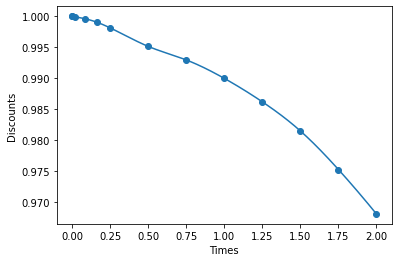

In [7]:
pw = RobustPWRegression(degree=3, solver="osqp", space="log")
pw.fit(times, discounts, splits=times)

plt.scatter(times, discounts)
plt.plot(time_space, pw.predict(time_space))

plt.xlabel('Times')
plt.ylabel('Discounts')
plt.show()

## Extrapolation

In many applications, we want to extrapolate outside the known points data range. RoPWR introduced extrapolation parameters ``extrapolation`` and ``extrapolation_bounds`` in version 1.0.0.

### Discount curve

We generate an extended time space. When ``space="linear"`` (default) four extrapolation methods are available:

- None: raise exception if value outside $(min(x_i), max(x_i))$
- "constant": the value of the regression at $(min(x_i), max(x_i))$ is used for constant extrapolation.
- "continue": the regression is extrapolated as is.
- "linear": the regression is linearly extrapolated using the derivatives at $(min(x_i), max(x_i))$.

In [8]:
time_space = np.linspace(0, 5, 1000)

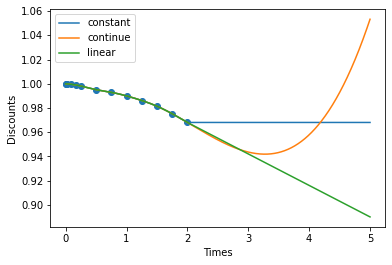

In [9]:
for extrapolation in ("constant", "continue", "linear"):
    pw = RobustPWRegression(degree=3, monotonic_trend="descending", solver="osqp",
                            extrapolation=extrapolation)

    pw.fit(times, discounts, splits=times)
    
    plt.plot(time_space, pw.predict(time_space), label=f"{extrapolation}")

plt.scatter(times, discounts)

plt.xlabel('Times')
plt.ylabel('Discounts')

plt.legend()
plt.show()

Extrapolation might return unexpected results, especially as the degree increases. For this particular case, we can improve the results using log-space.

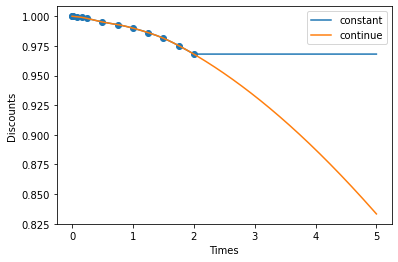

In [10]:
for extrapolation in ("constant", "continue"):
    pw = RobustPWRegression(degree=3, monotonic_trend="descending", solver="osqp",
                            extrapolation=extrapolation, space="log")

    pw.fit(times, discounts, splits=times)
    
    plt.plot(time_space, pw.predict(time_space), label=f"{extrapolation}")

plt.scatter(times, discounts)

plt.xlabel('Times')
plt.ylabel('Discounts')

plt.legend()
plt.show()

### Probability default curve

In this section example, we create a probability default curve with 15% deterministic one-year probability of default.

In [11]:
times = np.array([1, 2, 5, 10, 15])
probs = 1 - (1 - 0.15) ** times

time_space = np.linspace(0, 25, 1000)

We set the maximum value to 1 (100% probability) using ``extrapolation_bounds``. If the extrapolated values hit the bounds, constant extrapolation is applied from the intersection points onward.

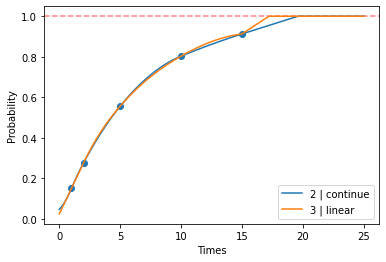

In [12]:
plt.scatter(times, probs)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)

for degree, extrapolation in ((2, "continue"), (3, "linear")):
    pw = RobustPWRegression(degree=degree, monotonic_trend="ascending", solver="osqp",
                            extrapolation=extrapolation, extrapolation_bounds=(0, 1))
    pw.fit(times, probs, splits=times)
    plt.plot(time_space, pw.predict(time_space), label=f'{degree} | {extrapolation}')

plt.xlabel('Times')
plt.ylabel('Probability')

plt.legend()
plt.show()